## 0. Download dataset
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [1]:
# https://drive.google.com/file/d/1kc6XNqHZJg27KeBuoAoYj70_1rT92191/view?usp=sharing
!gdown --id 1kc6XNqHZJg27KeBuoAoYj70_1rT92191

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191
From (redirected): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191&confirm=t&uuid=b06dcefa-2619-4ec8-be9a-e8325a46f85f
To: /content/vqa_coco_dataset.zip
100% 196M/196M [00:01<00:00, 126MB/s]


In [2]:
!unzip -q vqa_coco_dataset.zip

## 1. Import libraries

In [3]:
!pip install timm spacy pandas matplotlib transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.4 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import os
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel, ViTImageProcessor
from transformers import AutoTokenizer, RobertaModel

## 2. Read dataset

In [10]:
train_data = []
train_set_path = '/content/vaq2.0.TrainImages.txt'

with open(train_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        train_data.append(data_sample)

In [11]:
val_data = []
val_set_path = '/content/vaq2.0.DevImages.txt'

with open(val_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        val_data.append(data_sample)

In [12]:
test_data = []
test_set_path = '/content/vaq2.0.TestImages.txt'

with open(test_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        test_data.append(data_sample)

In [13]:
classes = set([sample['answer'] for sample in train_data])
classes_to_idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}
idx_to_classes = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}
print(idx_to_classes)

{0: 'yes', 1: 'no'}


## 3. Create Pytorch dataset

In [25]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        classes_to_idx,
        img_feature_extractor,
        text_tokenizer,
        device,
        transforms=None,
        root_dir='/content/val2014-resised'
    ):
        self.data = data
        self.root_dir = root_dir
        self.classes_to_idx = classes_to_idx
        self.img_feature_extractor = img_feature_extractor
        self.text_tokenizer = text_tokenizer
        self.device = device
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data[index]['image_path'])
        img = Image.open(img_path).convert('RGB')

        if self.transforms:
            img = self.transforms(img)

        if self.img_feature_extractor: # VitImageProcessor
            img = self.img_feature_extractor(images=img, return_tensors="pt")
            img = {k: v.to(self.device).squeeze(0) for k, v in img.items()}
        # Preprocessing of RoBERTa
        question = self.data[index]['question']
        if self.text_tokenizer:
            question = self.text_tokenizer(
                question,
                padding="max_length",
                max_length=20,
                truncation=True,
                return_tensors="pt"
            )
            question = {k: v.to(self.device).squeeze(0) for k, v in question.items()}


        label = self.data[index]['answer']
        label = torch.tensor(
            classes_to_idx[label],
            dtype=torch.long
        ).to(device)

        sample = {
            'image': img,
            'question': question,
            'label': label
        }

        return sample

In [26]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.CenterCrop(size=180),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomHorizontalFlip(),
    #trasnforms.RandomPerspective(distortion_scale=0.6),
    #transforms.ElasticTransform(),
    transforms.GaussianBlur(3),
    #transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    #transforms.RandomInvert()
])

In [27]:
img_feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
text_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = VQADataset(
    train_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device,
    transforms=data_transform
)
val_dataset = VQADataset(
    val_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)
test_dataset = VQADataset(
    test_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)

+ Test Vit Processor

In [17]:
img_feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
root_dir = '/content/val2014-resised'
img_name = train_data[0]['image_path']
img_path = os.path.join(root_dir, img_name)
img_pil = Image.open(img_path).convert('RGB')

img_features = img_feature_extractor(images=img_pil, return_tensors='pt')
print(img_features)



{'pixel_values': tensor([[[[ 0.3882,  0.4431,  0.5137,  ..., -0.7804, -0.7725, -0.7725],
          [ 0.4118,  0.4275,  0.4824,  ..., -0.7725, -0.7725, -0.7725],
          [ 0.4510,  0.4275,  0.4745,  ..., -0.7647, -0.7647, -0.7647],
          ...,
          [-0.4980, -0.2392, -0.0196,  ...,  0.7255,  0.8118,  0.6706],
          [-0.0667, -0.0510,  0.0118,  ...,  0.6000,  0.6078,  0.6941],
          [-0.0196, -0.0039,  0.0039,  ...,  0.3725,  0.6627,  0.7725]],

         [[ 0.2157,  0.2706,  0.3098,  ..., -0.7020, -0.7098, -0.7098],
          [ 0.2392,  0.2549,  0.2941,  ..., -0.6941, -0.7098, -0.7098],
          [ 0.2784,  0.2549,  0.2863,  ..., -0.6863, -0.6863, -0.6863],
          ...,
          [-0.6078, -0.3333, -0.1216,  ...,  0.5451,  0.6157,  0.4588],
          [-0.1294, -0.1137, -0.0510,  ...,  0.3804,  0.4118,  0.5216],
          [-0.0510, -0.0353, -0.0588,  ...,  0.1137,  0.4824,  0.6314]],

         [[-0.1059, -0.0353,  0.0510,  ..., -0.6941, -0.6941, -0.6941],
          [-0

+ Test Process : RoBERTa

In [19]:
text_tokenizer = AutoTokenizer.from_pretrained("roberta-base")

input_text = 'hello world'

output_text = text_tokenizer(
                input_text,
                padding="max_length",
                max_length=20,
                truncation=True,
                return_tensors="pt"
            )
print(output_text)


{'input_ids': tensor([[    0, 42891,   232,     2,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [28]:
train_batch_size = 256
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [29]:
## Test loader
test_loader = next(iter(train_loader))
print()

{'image': {'pixel_values': tensor([[[[-0.5765, -0.5451, -0.5059,  ...,  0.2784,  0.1922,  0.1451],
          [-0.5686, -0.5373, -0.4980,  ...,  0.0745,  0.0039, -0.0353],
          [-0.5529, -0.5294, -0.4902,  ..., -0.2000, -0.2471, -0.2627],
          ...,
          [-0.8980, -0.9059, -0.9137,  ..., -0.1216, -0.1373, -0.1451],
          [-0.9059, -0.9137, -0.9216,  ..., -0.1137, -0.1294, -0.1373],
          [-0.9137, -0.9216, -0.9216,  ..., -0.1059, -0.1216, -0.1294]],

         [[-0.6627, -0.6314, -0.5922,  ...,  0.2784,  0.2000,  0.1529],
          [-0.6549, -0.6235, -0.5843,  ...,  0.0745,  0.0039, -0.0275],
          [-0.6392, -0.6157, -0.5843,  ..., -0.2078, -0.2471, -0.2627],
          ...,
          [-0.8980, -0.9059, -0.9137,  ..., -0.1216, -0.1373, -0.1451],
          [-0.9059, -0.9137, -0.9216,  ..., -0.1137, -0.1294, -0.1373],
          [-0.9137, -0.9216, -0.9216,  ..., -0.1059, -0.1216, -0.1294]],

         [[-0.7255, -0.7098, -0.6784,  ...,  0.3725,  0.2941,  0.2471],
   

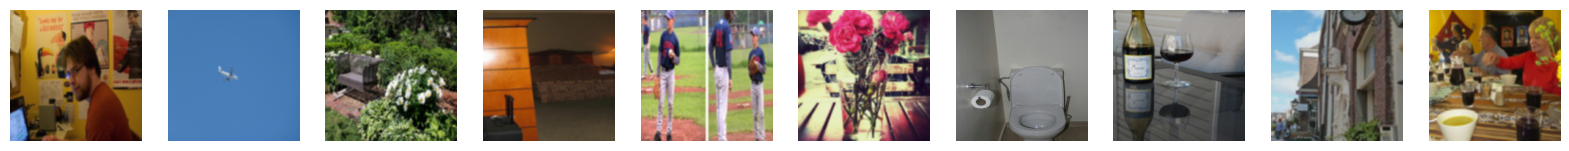

In [ ]:
root_dir='datasets/val2014-resised/'
img_to_show = 10
shift = 10
test_imgs = [
    os.path.join(root_dir, sample['image_path']) for sample in train_data[shift:shift+img_to_show]
]
fig, axes = plt.subplots(nrows=1, ncols=img_to_show, figsize=(20, 4))
for ax, img_path in zip(axes, test_imgs):
    img_pil = Image.open(img_path).convert('RGB')
    preprocessed_img = data_transform(img_pil)
    ax.imshow(preprocessed_img)
    ax.axis('off')
plt.show()

# 5. Create Model

In [ ]:
class VisualEncoder(nn.Module):
    def __init__(self):
        super(VisualEncoder, self).__init__()
        self.model = ViTModel.from_pretrained("google/vit-base-patch16-224")

    def forward(self, inputs):
        ## input is dictionary have pixelvalues of images
        outputs = self.model(**inputs)

        return outputs.pooler_output # feature after Vit

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.model = RobertaModel.from_pretrained("roberta-base")

    def forward(self, inputs):
        # input is dictionary have input_ids and attn_mask
        outputs = self.model(**inputs)

        return outputs.pooler_output # feature after RoBERTa

In [ ]:
class Classifier(nn.Module):
    def __init__(
        self,
        input_size=768*2,
        # input_size=512,
        hidden_size=512,
        n_layers=1,
        dropout_prob=0.2,
        n_classes=2
    ):
        super(Classifier,self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout_prob)
        # self.fc = nn.Linear(input_size, 256)
        # self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(hidden_size * 2, n_classes)

    def forward(self,x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        # x = self.fc(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        x = self.fc1(x)

        return x

In [ ]:
class VQAModel(nn.Module):
    def __init__(
        self,
        visual_encoder,
        text_encoder,
        classifier
    ):
        super(VQAModel, self).__init__()
        self.visual_encoder = visual_encoder
        self.text_encoder = text_encoder
        self.classifier = classifier
        # self.visual_latent = nn.Linear(768, 512)
        # self.text_latent = nn.Linear(768, 512)


    def forward(self, image, question):
        text_out = self.text_encoder(question)
        image_out = self.visual_encoder(image)

        # text_out = self.text_latent(text_out)
        # image_out = self.visual_latent(image_out)
        # x = text_out * image_out
        x = torch.cat((text_out, image_out), dim=1)
        x = self.classifier(x) # Pass to lstm . LSTM because can mapping img, text good

        return x

    def freeze(self, visual=True, textual=True, clas=False):
        if visual:
            for n,p in self.visual_encoder.named_parameters():
                p.requires_grad = False
        if textual:
            for n,p in self.text_encoder.named_parameters():
                p.requires_grad = False
        if clas:
            for n,p in self.classifier.named_parameters():
                p.requires_grad = False

In [ ]:
n_classes = len(classes)
hidden_size = 256
n_layers = 2
dropout_prob = 0.2

text_encoder = TextEncoder().to(device)
visual_encoder = VisualEncoder().to(device)
classifier = Classifier(
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob,
    n_classes=n_classes
).to(device)

model = VQAModel(
    visual_encoder=visual_encoder,
    text_encoder=text_encoder,
    classifier=classifier
).to(device)
model.freeze()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
inputs = next(iter(train_loader))

model.eval()
with torch.no_grad():
    image = inputs['image']
    question = inputs['question']
    output = model(image, question)
    print(output.shape)

torch.Size([256, 2])


## 6. Training

In [ ]:
def evaluate(model, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for idx, inputs in enumerate(dataloader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [ ]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, inputs in enumerate(train_loader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses

In [ ]:
lr = 1e-3
epochs = 100
scheduler_step_size = epochs * 0.6
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
)

EPOCH 1:	Train loss: 0.6970	Val loss: 0.6900	Val Acc: 0.5358606557377049
EPOCH 2:	Train loss: 0.6897	Val loss: 0.6858	Val Acc: 0.5466188524590164
EPOCH 3:	Train loss: 0.6812	Val loss: 0.6849	Val Acc: 0.5589139344262295
EPOCH 4:	Train loss: 0.6714	Val loss: 0.6765	Val Acc: 0.5840163934426229
EPOCH 5:	Train loss: 0.6545	Val loss: 0.6740	Val Acc: 0.5901639344262295
EPOCH 6:	Train loss: 0.6334	Val loss: 0.6738	Val Acc: 0.5993852459016393
EPOCH 7:	Train loss: 0.6047	Val loss: 0.6684	Val Acc: 0.6060450819672131
EPOCH 8:	Train loss: 0.5681	Val loss: 0.6849	Val Acc: 0.6065573770491803
EPOCH 9:	Train loss: 0.5151	Val loss: 0.7003	Val Acc: 0.6209016393442623
EPOCH 10:	Train loss: 0.4667	Val loss: 0.7066	Val Acc: 0.6460040983606558
EPOCH 11:	Train loss: 0.4201	Val loss: 0.7514	Val Acc: 0.6398565573770492
EPOCH 12:	Train loss: 0.3923	Val loss: 0.7326	Val Acc: 0.649077868852459
EPOCH 13:	Train loss: 0.3428	Val loss: 0.7740	Val Acc: 0.6521516393442623
EPOCH 14:	Train loss: 0.3251	Val loss: 0.8054	Va

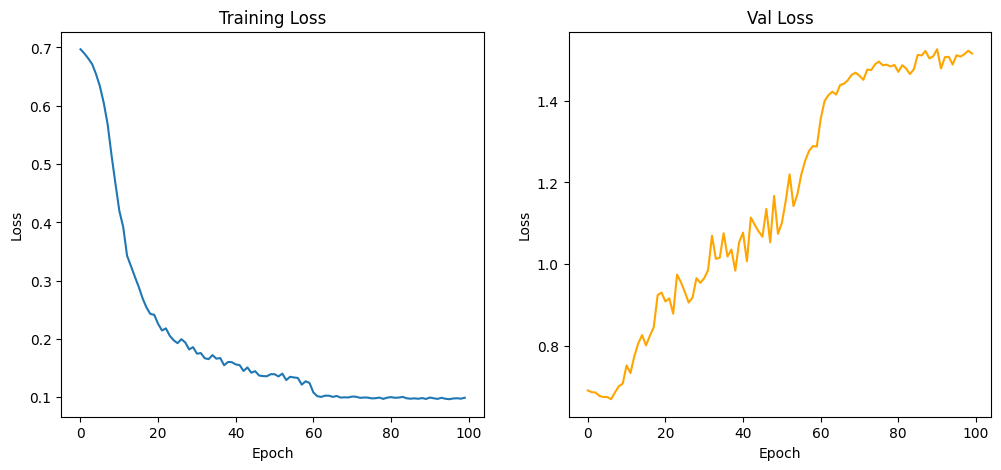

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## 7. Evaluation

In [ ]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.7054303278688525
Test accuracy:  0.701780415430267
